
# Generative Adversarial Netowrk - GAN on fashion dataset from mnist



In [22]:
import tensorflow as tf
import numpy as np

# confirm GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [24]:
dataset = np.concatenate([x_train,x_test], axis = 0)
# normalize images from [0,255] to [0,1]
dataset = np.expand_dims(dataset, -1).astype('float32')/255

In [25]:
batch_size = 64

#convolution layers work 3 channels
dataset = np.reshape(dataset, (-1,28,28,1))
#create a tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# set the batch size otherwise it reads one image at a time
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

## Model

In [26]:
from tensorflow import keras
from keras import layers
from keras.layers import LeakyReLU

In [27]:
# the generator's input is a noise vector
# hyperparametes that also requisers fine tuning
noise_dim = 150

# design a generator model with upsampling layers in GANs practices,
# usually the generator has leaky relu activation while the discriminator has relu #best practices
generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (noise_dim,)),
    layers.Dense(7*7*256),
    layers.Reshape(target_shape = (7,7,256)),
    layers.Conv2DTranspose(256,3,activation=LeakyReLU(), strides = 2, padding = 'same'),
    layers.Conv2DTranspose(128,3,activation=LeakyReLU(), strides = 2, padding = 'same'),
    layers.Conv2DTranspose(1,3,activation='sigmoid', padding = 'same'),
])

generator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 12544)               │       1,894,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,780,417 (10.61 MB)

 Trainable params: 2,780,417 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# design a discriminator with downsampling layers
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = (28,28,1)), #28x28x1 image x grey scale
    layers.Conv2D(256,3, activation = 'relu', strides = 2, padding ='same'),
    layers.Conv2D(128,3, activation = 'relu', strides = 2, padding ='same'),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation ='sigmoid') #true or fake image
])

discriminator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,137 (2.67 MB)

 Trainable params: 699,137 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# set different learning rates for the generator and discriminator
# we want to maintain the game balance until we arrive at the nash-equilibria
# if the discriminator gets very strong or very weak the adversarial game fails
# higher learning rates impact the stability of the adversarial game severely

optimizerG = keras.optimizers.Adam(learning_rate= 0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate= 0.00003, beta_1=0.5)

#binary classifier (real vs fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

#accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

In [30]:
# observe the annotation allows for efficient native tensorflow compiling
@tf.function
def trainDStep(data):
  # the btach size is (32,28,28,1) so extracts 32 value
  batchSize = tf.shape(data)[0]

  #create a noise vector as generator input sampled from Gaussian Random Normal
  noise = tf.random.normal(shape = (batchSize,noise_dim))

  #concatenate the real and fake labels
  y_true = tf.concat(
      [
          # the original data is real, labeled with 1
          tf.ones(batchSize,1),
          # the forged data is fake, labeled with 0
          tf.zeros(batchSize,1)
      ],
      axis =0
  )

  #record the calculate gradients
  with tf.GradientTape() as tape:
    #generate forged samples
    fake = generator(noise)
    #concatenate real and forged data
    x = tf.concat([data,fake], axis =0)
    #see if discriminator detects them
    y_pred = discriminator(x)
    # calculate loss
    discriminatorLoss = lossFn(y_true, y_pred)

  # apply the backward path and update weights
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads,discriminator.trainable_weights))

  # report accuracy
  dAccMetric.update_state(y_true, y_pred)

  # return the loss for visualization
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
  }

In [35]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, noise_dim))
  # when training the generator, we want it to maximize the probability that its
  # output is classified as real, remember the min-max game
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  gAccMetric.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

Visualize images

In [32]:
from matplotlib import pyplot as plt

def plotImages(model):
  images = model(np.random.normal(size=(81,noise_dim)))

  plt.figure(figsize=(9,9))

  for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image,-1), cmap = "Greys_r")
    plt.axis('off')
  plt.show()

## Training

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


E:0, Loss G:2.7847, Loss D:0.1293, Acc G:%0.31, Acc D:%97.60


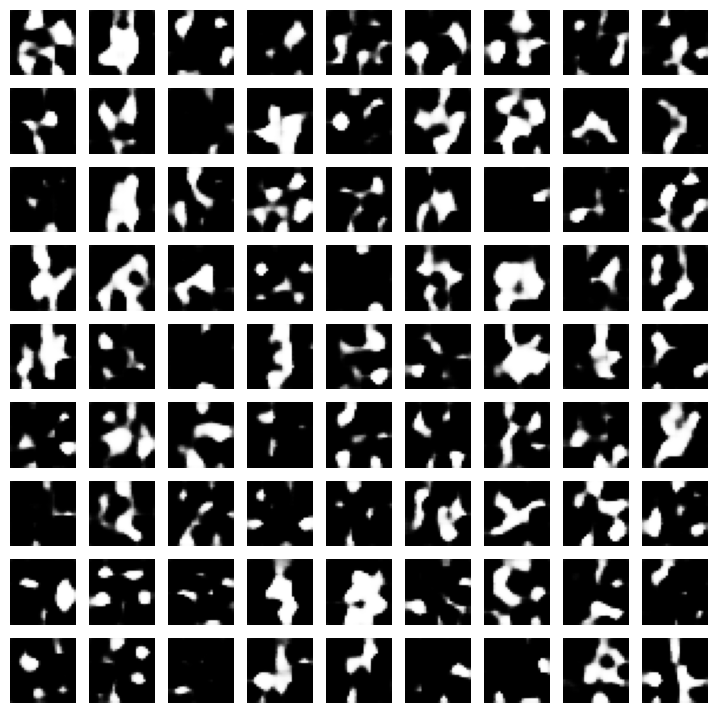

E:1, Loss G:2.9903, Loss D:0.1240, Acc G:%0.85, Acc D:%97.90
E:2, Loss G:2.9504, Loss D:0.1500, Acc G:%1.39, Acc D:%97.22


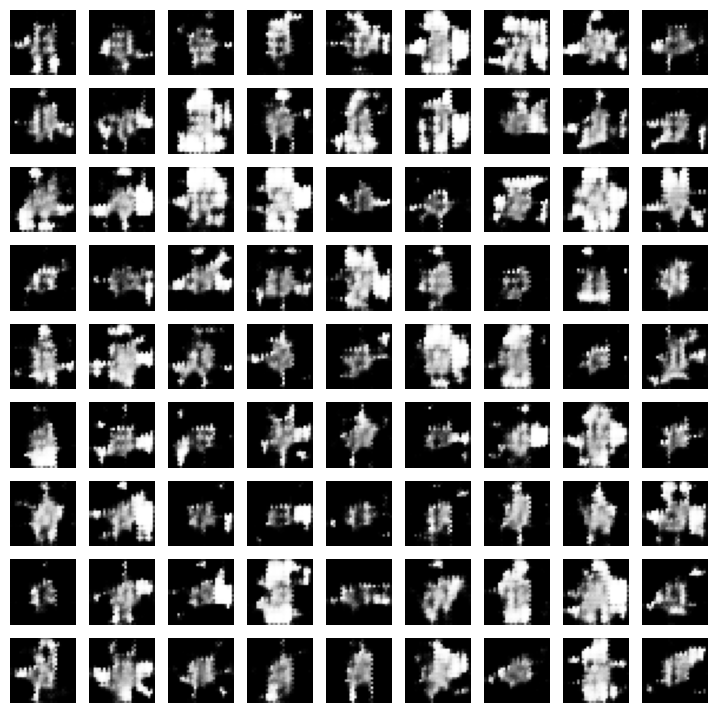

E:3, Loss G:2.2561, Loss D:0.2230, Acc G:%1.95, Acc D:%96.23
E:4, Loss G:1.9205, Loss D:0.3132, Acc G:%2.71, Acc D:%94.94


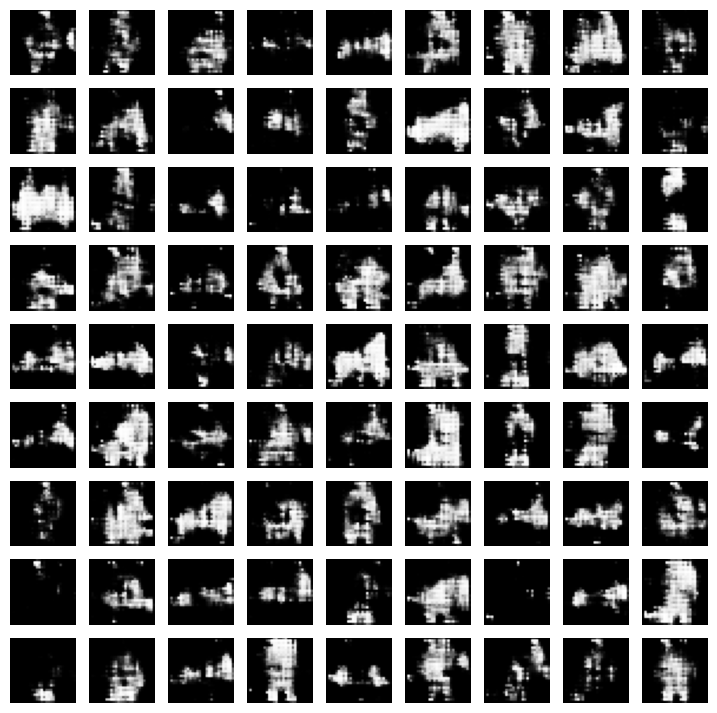

E:5, Loss G:1.8004, Loss D:0.3275, Acc G:%3.68, Acc D:%93.59
E:6, Loss G:1.6166, Loss D:0.3776, Acc G:%4.64, Acc D:%92.46


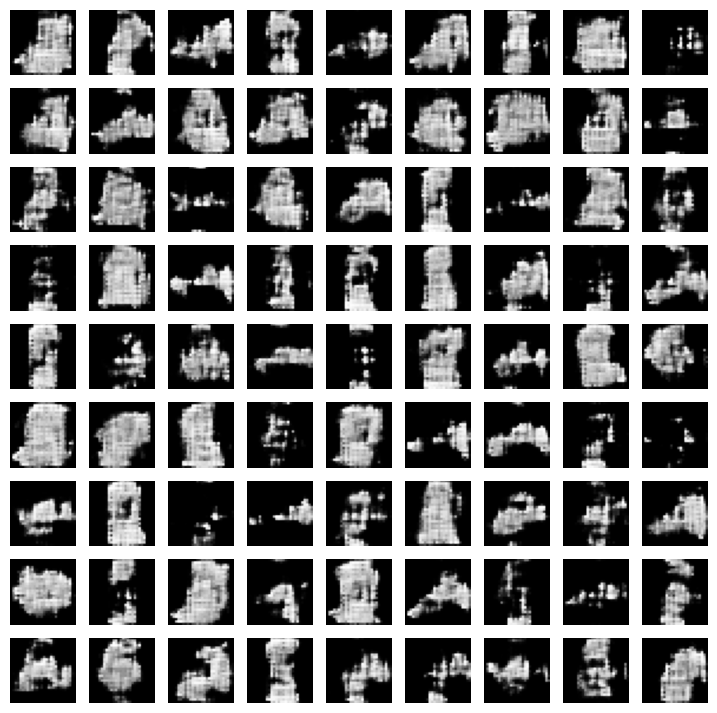

E:7, Loss G:1.5953, Loss D:0.3777, Acc G:%5.50, Acc D:%91.53
E:8, Loss G:1.5271, Loss D:0.3856, Acc G:%6.25, Acc D:%90.67


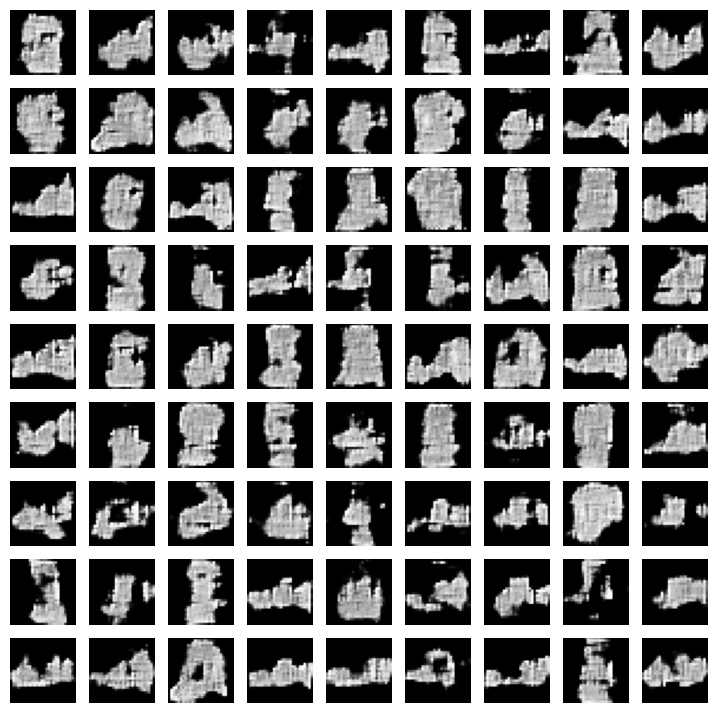

E:9, Loss G:1.5826, Loss D:0.3440, Acc G:%6.65, Acc D:%90.18
E:10, Loss G:1.6609, Loss D:0.3262, Acc G:%6.75, Acc D:%90.01


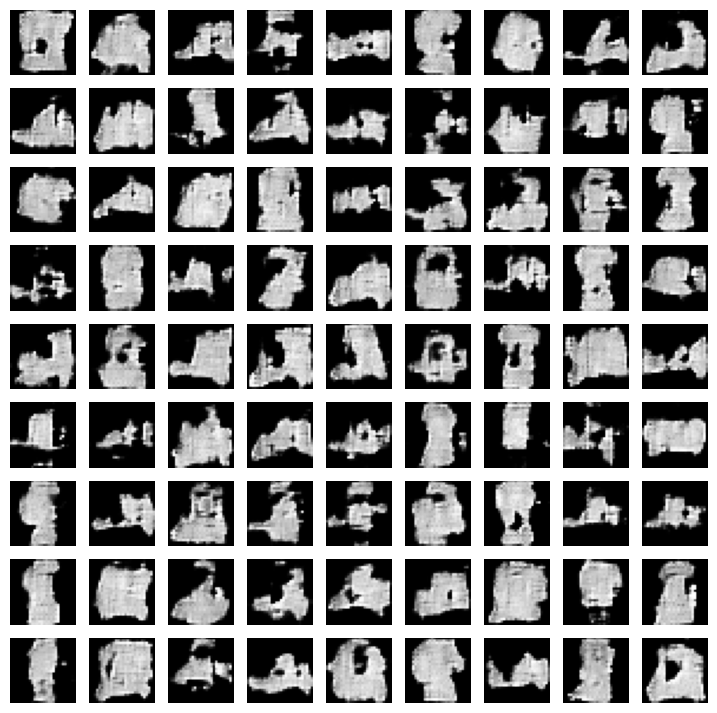

E:11, Loss G:1.7226, Loss D:0.3179, Acc G:%6.79, Acc D:%89.87
E:12, Loss G:1.8332, Loss D:0.2999, Acc G:%6.78, Acc D:%89.77


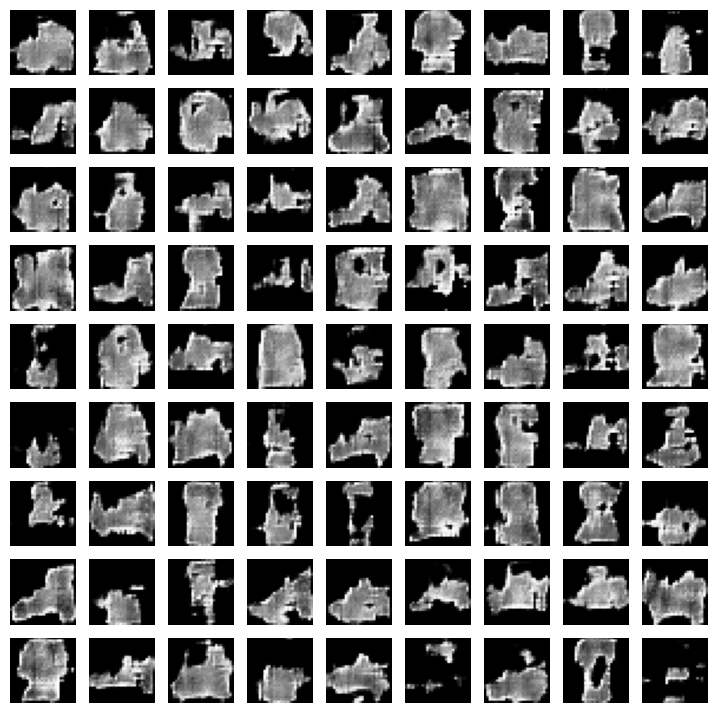

E:13, Loss G:1.9684, Loss D:0.2797, Acc G:%6.71, Acc D:%89.78
E:14, Loss G:1.8996, Loss D:0.2958, Acc G:%6.69, Acc D:%89.78


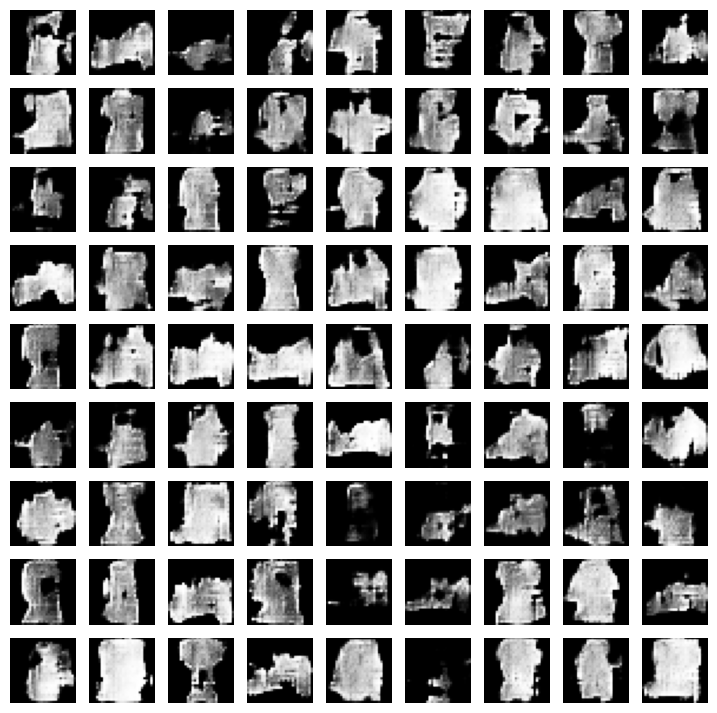

E:15, Loss G:1.8786, Loss D:0.3214, Acc G:%6.78, Acc D:%89.68
E:16, Loss G:1.8776, Loss D:0.3256, Acc G:%6.91, Acc D:%89.53


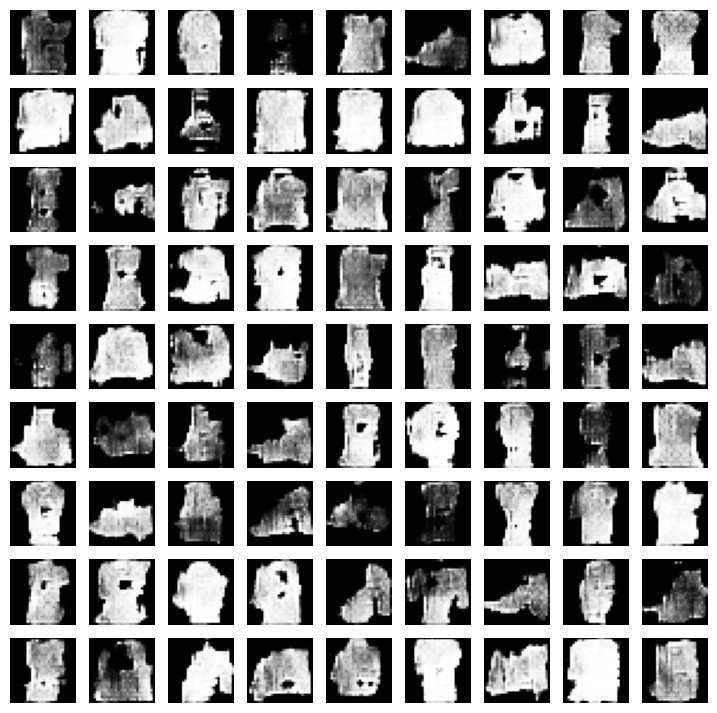

E:17, Loss G:1.8610, Loss D:0.3218, Acc G:%7.01, Acc D:%89.41
E:18, Loss G:1.8730, Loss D:0.3067, Acc G:%7.07, Acc D:%89.33


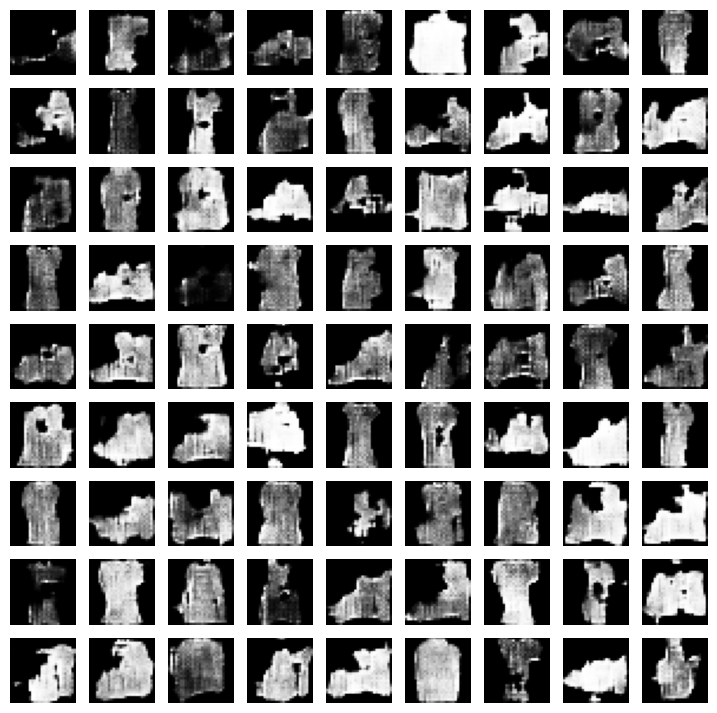

E:19, Loss G:1.9107, Loss D:0.2996, Acc G:%7.11, Acc D:%89.30
E:20, Loss G:1.9143, Loss D:0.3069, Acc G:%7.13, Acc D:%89.28


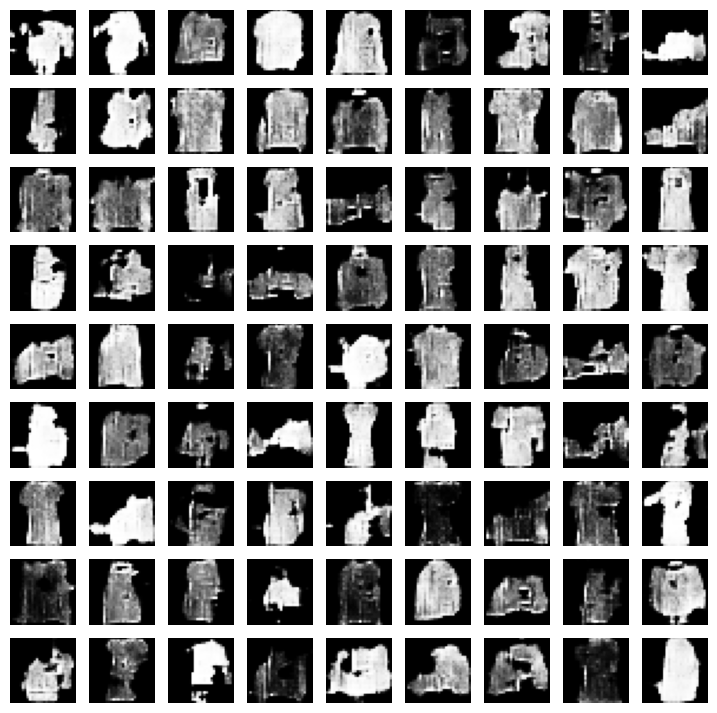

E:21, Loss G:1.8862, Loss D:0.3096, Acc G:%7.16, Acc D:%89.23
E:22, Loss G:1.8898, Loss D:0.3084, Acc G:%7.19, Acc D:%89.18


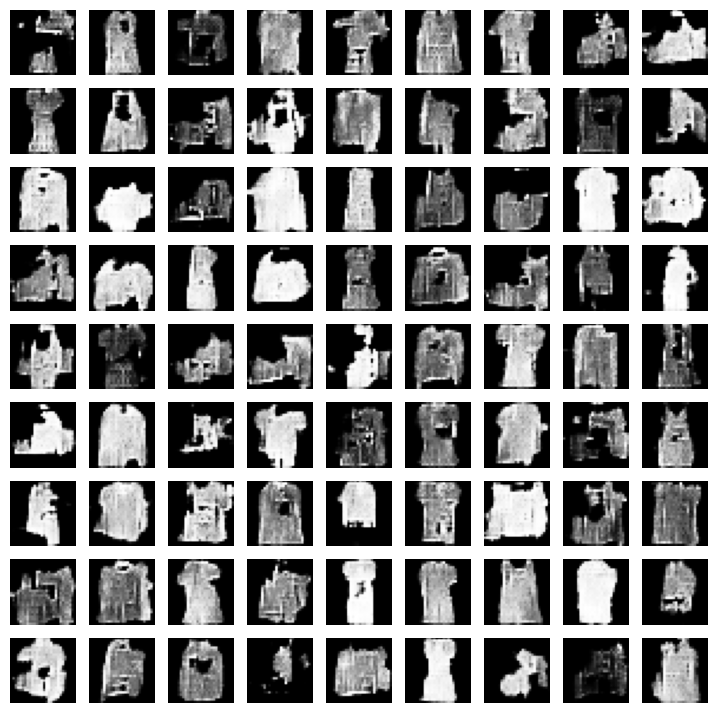

E:23, Loss G:1.8950, Loss D:0.3099, Acc G:%7.21, Acc D:%89.14
E:24, Loss G:1.8991, Loss D:0.3104, Acc G:%7.23, Acc D:%89.09


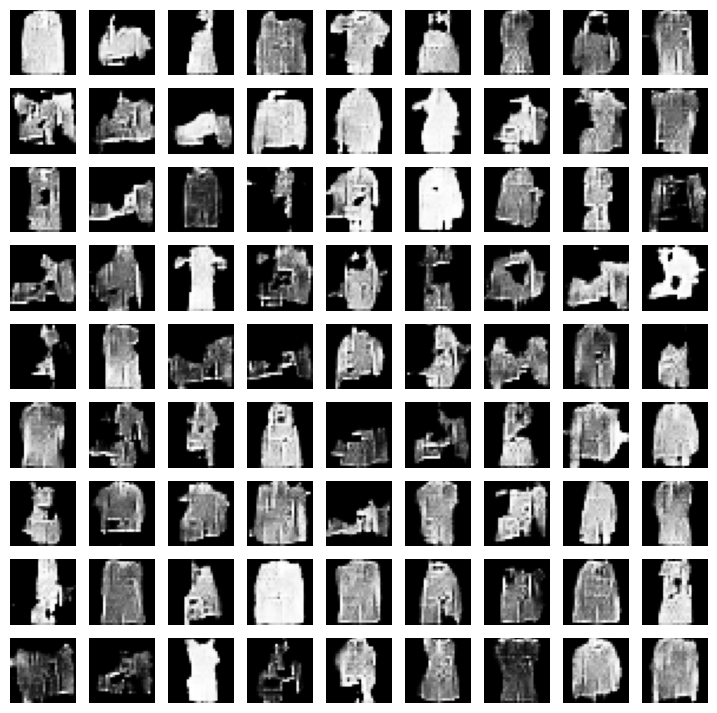

E:25, Loss G:1.8922, Loss D:0.3104, Acc G:%7.23, Acc D:%89.04
E:26, Loss G:1.8737, Loss D:0.3159, Acc G:%7.23, Acc D:%89.00


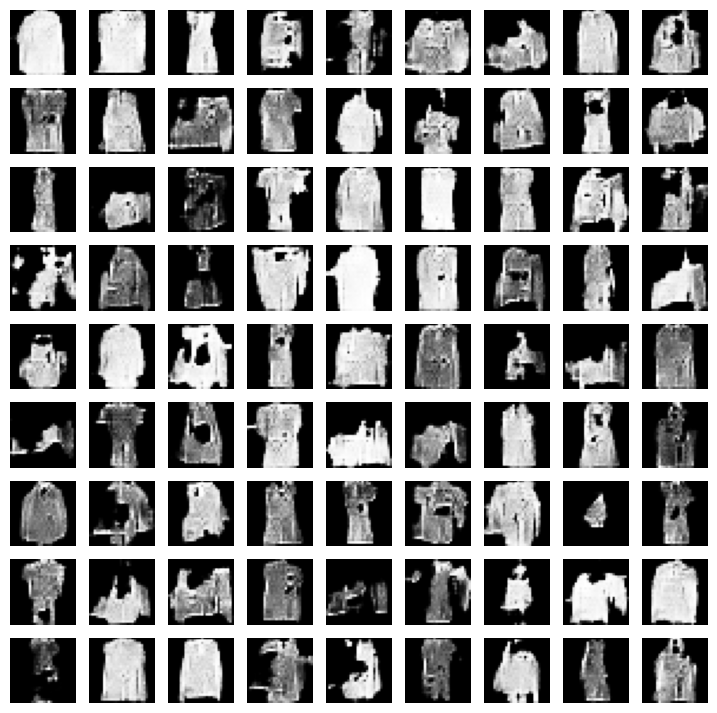

E:27, Loss G:1.8271, Loss D:0.3220, Acc G:%7.24, Acc D:%88.94
E:28, Loss G:1.7928, Loss D:0.3344, Acc G:%7.26, Acc D:%88.87


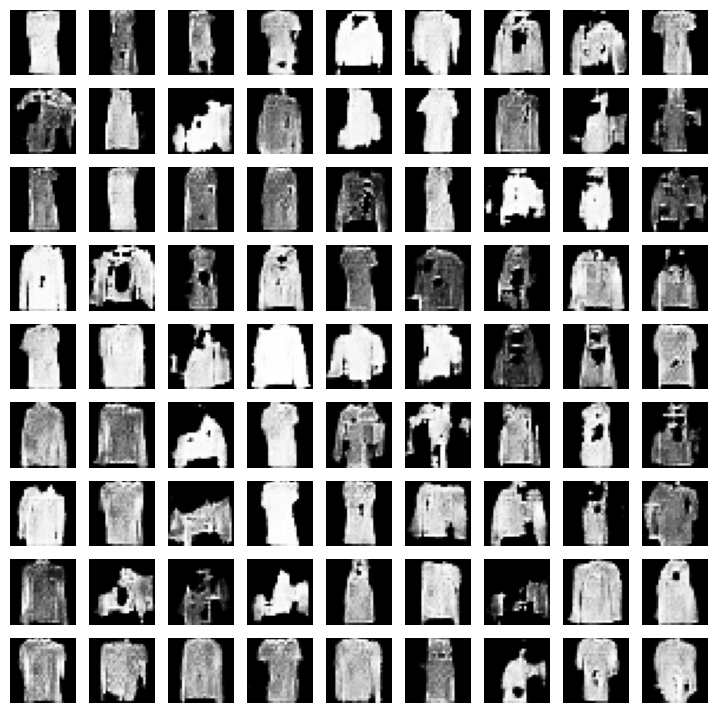

E:29, Loss G:1.7578, Loss D:0.3435, Acc G:%7.30, Acc D:%88.78


In [36]:
# we don't use the model.fit method any more since the original GANs paper trained
# the discriminator for 5 steps and then the generator for 1 step
# the value 5 is subject to fine-tuning depending on the model design and the dataset
# in this example, training both for 1 step
# note: the adversarial game may diverge after it has converged
# that's why it is customary to visualize the generated images every few epochs
# some even put the images together into a video
for epoch in range(30):

  # accumulate the loss to calculate the average at the end of the epoch
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0

  # loop the dataset one batch at a time
  for batch in dataset:

    # train the discriminator
    # remember you could repeat these 2 lines of code for K times
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    # train the generator
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    # increment the counter
    cnt += 1

  # log the performance
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))

  if epoch % 2 == 0:
    plotImages(generator)